# Clustering Station Locations

This file implements the main clustering of stations used in the paper. 

1. Load data
2. Pre-process data (see clustering_allUS_preprocessing file)
3. Elbow plot
4. Plotting cluster results, with alternative values of K
5. Save

In [1]:
plotsavedate='20251031'
savedate = '20251031'

In [12]:
folder = '' # path to data
figure_folder = '' # path to figures folder

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.colors import LinearSegmentedColormap

In [4]:
from clustering_allUS_preprocessing import ClusteringData
dataobj = ClusteringData(savedate=plotsavedate)

## 1. Load data

In [5]:
string_cols = ['unique_ID', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State_abbr', 'ZIP',  'Status Code', 'EV Network', 'Owner Type Code', 'Open Date',  'EV Pricing', 'Facility Type', 'Groups With Access Code',  'Access Days Time', 'COUNTYNAME', 'State',  'clostestname_PoI', 'clostestname_ind', 'clostestname_topcat', 'utility', 'utilitytype', 'STATEFP']
dtype_dict = {i:'string' for i in string_cols}
combined_df_stations = pd.read_csv(folder + '20_level_stations_US_compiled_250415.zip', index_col=0,
                                   dtype=dtype_dict, usecols=dataobj.cols_cluster+['unique_ID', 'State', 'BGFP', 'TRACTFP', 'STATEFP', 'COUNTYFP', 'raw_visit_counts', 'total_pop_byBG'])
dataobj.df = combined_df_stations.copy()

## 2. Pre-process
Using the ClusteringData class

In [6]:
dataobj.clean()
dataobj.normalize()
dataobj.transform()
dataobj.X_std_save.to_csv(folder+'scaled_clustering_inputs_'+savedate+'.csv')

## 3. Elbow plot

In [8]:
def run_kmeans_elbow(data, kmin, kmax, n_init=10, savestr=None, return_models=True):
    
    distorsions = []
    if return_models:    
        models = {}
        for k in range(kmin, kmax):
            print(k)
            models[k] = KMeans(n_clusters=k, n_init=n_init, random_state=12345)
            models[k].fit(data)
            distorsions.append(models[k].inertia_)
    else:
        for k in range(kmin, kmax):
            print(k)
            km = KMeans(n_clusters=k, n_init=n_init, random_state=12345)
            km.fit(data)
            distorsions.append(km.inertia_)
        
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(np.arange(kmin, kmax), distorsions, '-o')
    plt.subplot(122)
    d1 = [int(distorsions[i+1]) - int(distorsions[i]) for i in range(len(distorsions)-1)]
    d2 = [int(d1[i+1]) - int(d1[i]) for i in range(len(d1)-1)]
    plt.plot(np.arange(kmin+1, kmax-1), d2, '-o')
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+'.pdf', bbox_inches='tight', dpi=400)
        plt.savefig(savestr+'.png', bbox_inches='tight', dpi=400)
    plt.show()
    
    if return_models:
        return models, distorsions
    else:
        return distorsions

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


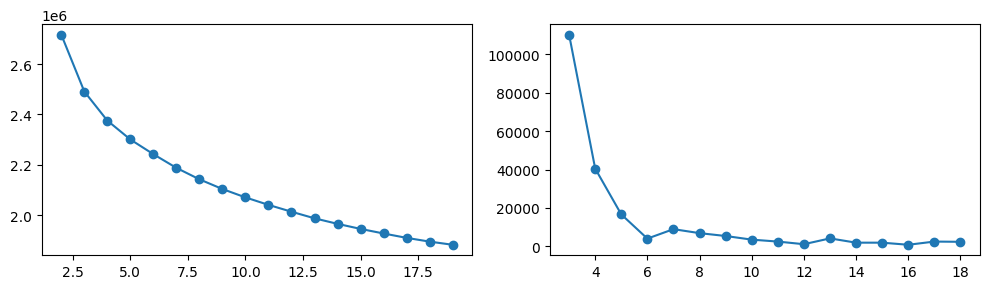

In [9]:
inertias = run_kmeans_elbow(dataobj.X_std_df.values, 2, 20, n_init = 100, return_models=False)

In [10]:
pd.DataFrame({'inertias':inertias, 
              'k':np.arange(2, 20)}).to_csv(folder + 'clustering_rows_kmeansinertia_smallk_'+plotsavedate+'_inertiavalues.csv')

## Figure S21

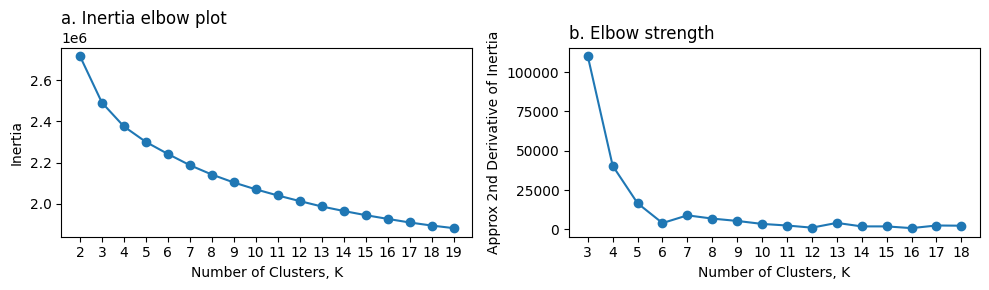

In [13]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(2, 20), inertias, '-o')
plt.xlabel('Number of Clusters, K')
plt.xticks(np.arange(2, 20))
plt.ylabel('Inertia')
plt.title('a. Inertia elbow plot', loc='left')
plt.subplot(122)
d1 = [int(inertias[i+1]) - int(inertias[i]) for i in range(len(inertias)-1)]
d2 = [int(d1[i+1]) - int(d1[i]) for i in range(len(d1)-1)]
plt.plot(np.arange(2+1, 20-1), d2, '-o')
plt.xlabel('Number of Clusters, K')
plt.xticks(np.arange(3, 19))
plt.ylabel('Approx 2nd Derivative of Inertia')
plt.title('b. Elbow strength', loc='left')
plt.tight_layout()
plt.savefig(figure_folder + 'figureS21_elbow_plot_nice_'+plotsavedate+'.pdf', bbox_inches='tight', dpi=400)
plt.savefig(figure_folder + 'figureS21_elbow_plot_nice_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()

## 4. Plot, Interpret, and Select Number of Clusters

In [20]:
def run_and_interpret(dataobj, k, savedate, save=False, return_model=False, fignumber=''):
    
    kmeans_here = KMeans(n_clusters=k, random_state=12345, n_init=100).fit(dataobj.X_std_df.values)
    df_kmeans_centers = pd.DataFrame(kmeans_here.cluster_centers_, columns=dataobj.cols_cluster)
    if save:
        plot_v2(dataobj, df_kmeans_centers, k, savestr='figure'+fignumber+'_clustering_kmeansrows_nc'+str(k)+'_'+savedate, save=True)
    else:
        plot_v2(dataobj, df_kmeans_centers, k, savestr=None, save=True)

    dataobj.X_std_save['Kmeans_nc'+str(k)] = kmeans_here.labels_
    
    if return_model:
        return dataobj, kmeans_here
    else:
        return dataobj

In [21]:
def plot_v2(dataobj, df, nc, savestr=None, save=False):
    
    cm = LinearSegmentedColormap.from_list('Cmap_grey', ['white', 'k'], N=50)
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, height_ratios=[8, 11])
    for row in range(2):
        for col in range(3):
            col_cluster = 3*row + col
            columns = dataobj.column_ordering[dataobj.column_ordering['Col_Cluster_forDisplay_v2']==col_cluster]['Column'].values
            columns_nice = dataobj.column_ordering[dataobj.column_ordering['Col_Cluster_forDisplay_v2']==col_cluster]['Columns_NiceName'].values
            tmp = df.loc[:, columns].copy()
            axes[row, col].imshow(tmp.T, vmin=-1.5, vmax=1.5, cmap=cm, aspect='auto')
            axes[row, col].set_xticks(np.arange(0, nc))
            if row == 1:
                axes[row, col].set_xlabel('Cluster Number')
            axes[row, col].set_yticks(np.arange(0, len(columns)))
            axes[row, col].set_yticklabels(columns_nice)

            axes[row, col].set_ylabel(dataobj.section_labels[col_cluster], fontsize=14)

    plt.tight_layout()
    if save:
        if savestr is not None:
            plt.savefig(figure_folder + savestr+'.pdf', bbox_inches='tight', dpi=400)
            plt.savefig(figure_folder + savestr+'.png', bbox_inches='tight', dpi=400)
    plt.show()

## Main case: K=8
### Figure S26

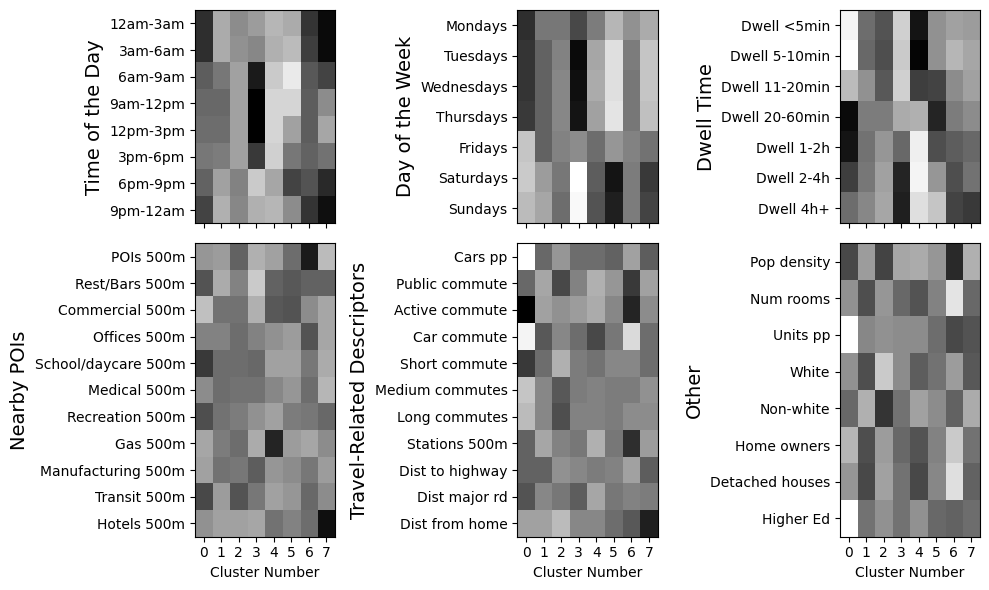

In [22]:
dataobj, kmeans8 = run_and_interpret(dataobj, 8, plotsavedate, save=True, return_model=True, fignumber='S26')

In [29]:
pd.DataFrame(kmeans8.cluster_centers_, columns=dataobj.X_std_df.columns).to_csv(folder + 'cluster_centers_kmeans_nc8_'+plotsavedate+'.csv')

## Alternative K=4
### Figure S23

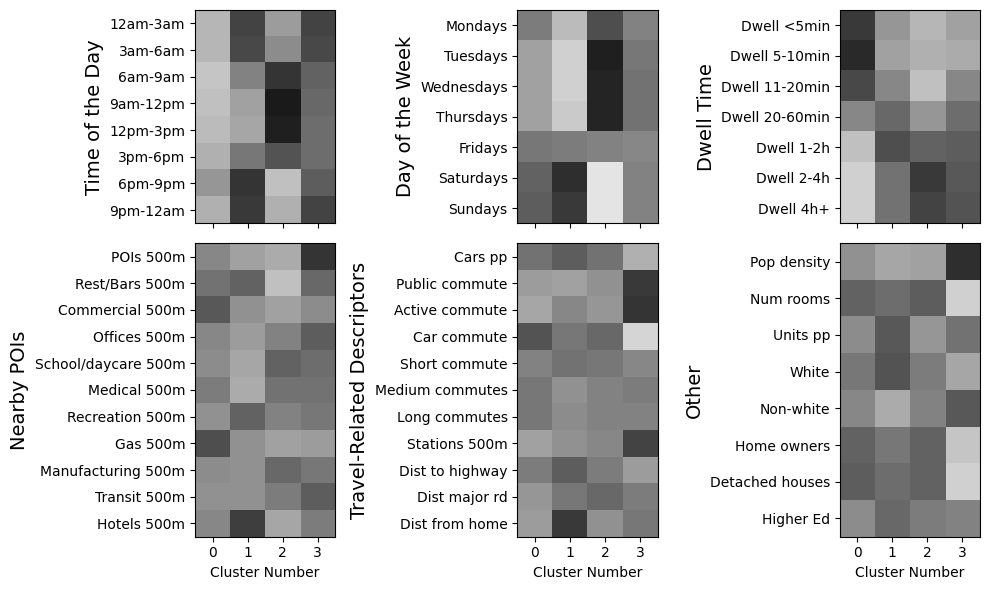

In [30]:
dataobj, kmeans4 = run_and_interpret(dataobj, 4, plotsavedate, save=True, return_model=True, fignumber='S23')
pd.DataFrame(kmeans4.cluster_centers_, 
             columns=dataobj.X_std_df.columns).to_csv(folder + 'cluster_centers_kmeans_nc4_'+plotsavedate+'.csv')

## Alternative K=5
### Figure S24

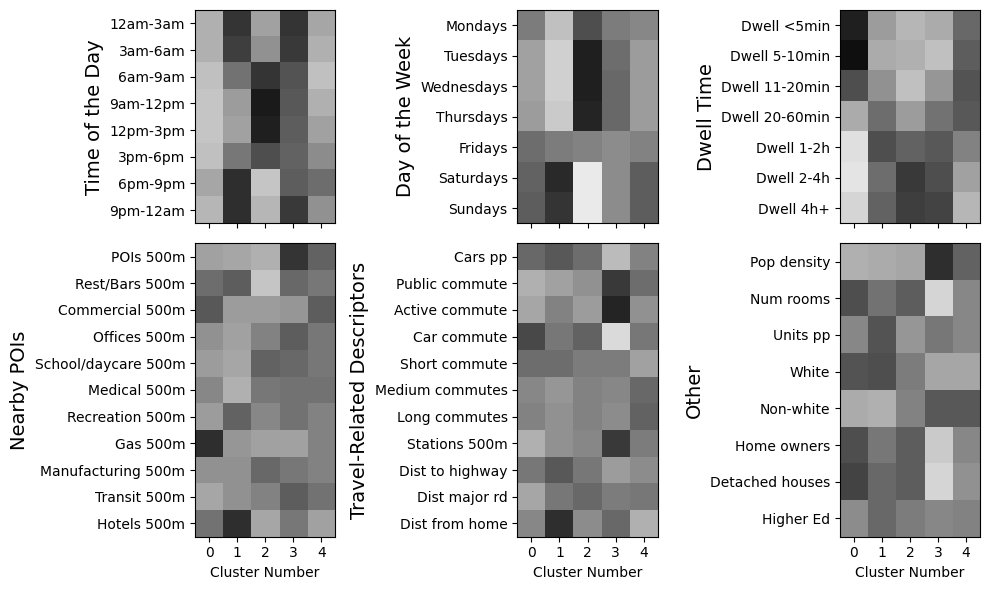

In [31]:
dataobj, kmeans5 = run_and_interpret(dataobj, 5, plotsavedate, save=True, return_model=True, fignumber='S24')
pd.DataFrame(kmeans5.cluster_centers_, columns=dataobj.X_std_df.columns).to_csv(folder + 'cluster_centers_kmeans_nc5_'+plotsavedate+'.csv')

## Alternative K=7
### Figure S25

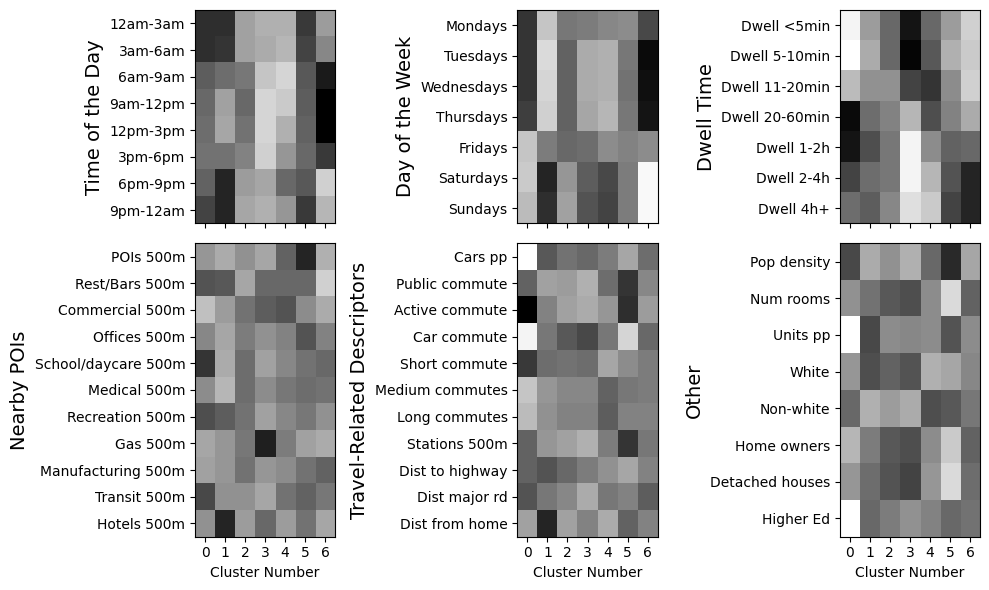

In [32]:
dataobj, kmeans7 = run_and_interpret(dataobj, 7, plotsavedate, save=True, return_model=True, fignumber='S25')
pd.DataFrame(kmeans7.cluster_centers_, 
             columns=dataobj.X_std_df.columns).to_csv(folder + 'cluster_centers_kmeans_nc7_'+plotsavedate+'.csv')

## Alternative K=13
### Figure S27

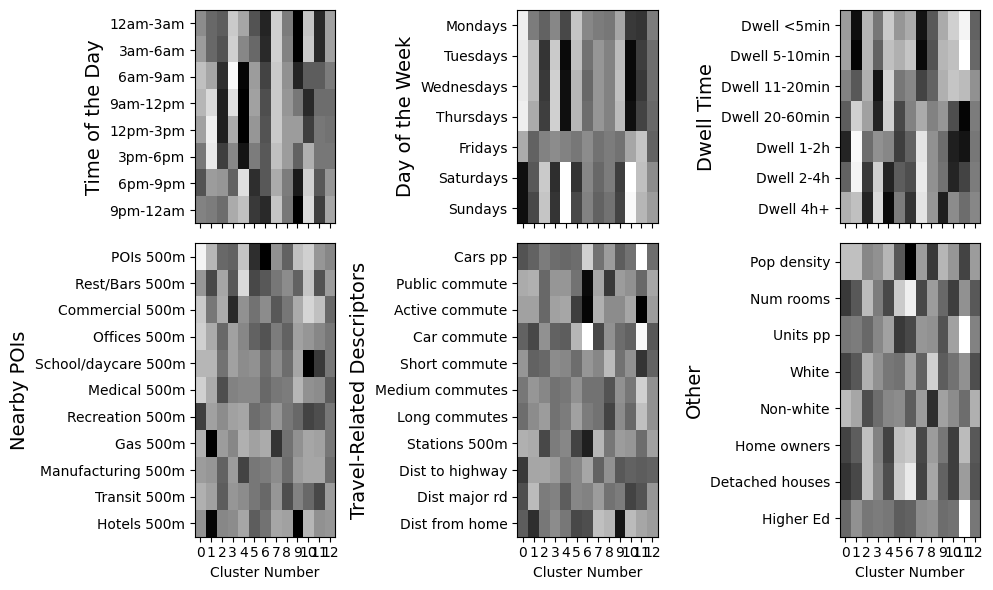

In [33]:
dataobj, kmeans13 = run_and_interpret(dataobj, 13, plotsavedate, save=True, return_model=True, fignumber='S27')
pd.DataFrame(kmeans13.cluster_centers_, columns=dataobj.X_std_df.columns).to_csv(folder + 'cluster_centers_kmeans_nc13_'+plotsavedate+'.csv')

## 5. Save

In [34]:
dataobj.X_std_save.to_csv(folder+'scaled_clustering_inputs_labelled_'+savedate+'.csv')
all_labels = dataobj.X_std_save.loc[:, ['unique_ID', 'Kmeans_nc4', 'Kmeans_nc5', 'Kmeans_nc7', 'Kmeans_nc8', 'Kmeans_nc13']].copy()
all_labels.to_csv(folder+'/clustering_labels_saved_'+savedate+'.csv')